# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

Признаки:
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

Целевой признак
- Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sn
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
import lightgbm as lgb

In [2]:
df = pd.read_csv('/datasets/autos.csv') 
# df = pd.read_csv('datasets/autos.csv') 

df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
#name of columns into the snake case 
df.columns = ['date_crawled',  'price', 'vehicle_type', 'registration_year',  'gear_box',  
              'power', 'model', 'kilometer', 'registration_month',  'fuel_type',  'brand',
              'not_repaired',  'date_created',  'number_of_pictures',  'postal_code',  'last_seen'] 

In [4]:
df.drop(['date_crawled', 'last_seen', 'date_created', 'postal_code'], inplace=True, axis=1)

In [5]:
#check for gaps
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               354369 non-null  int64 
 1   vehicle_type        316879 non-null  object
 2   registration_year   354369 non-null  int64 
 3   gear_box            334536 non-null  object
 4   power               354369 non-null  int64 
 5   model               334664 non-null  object
 6   kilometer           354369 non-null  int64 
 7   registration_month  354369 non-null  int64 
 8   fuel_type           321474 non-null  object
 9   brand               354369 non-null  object
 10  not_repaired        283215 non-null  object
 11  number_of_pictures  354369 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 32.4+ MB


In [6]:
#check the duplicates
df.duplicated().sum()

27543

In [7]:
df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 326826 entries, 0 to 326825
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               326826 non-null  int64 
 1   vehicle_type        291577 non-null  object
 2   registration_year   326826 non-null  int64 
 3   gear_box            309248 non-null  object
 4   power               326826 non-null  int64 
 5   model               308294 non-null  object
 6   kilometer           326826 non-null  int64 
 7   registration_month  326826 non-null  int64 
 8   fuel_type           295704 non-null  object
 9   brand               326826 non-null  object
 10  not_repaired        260399 non-null  object
 11  number_of_pictures  326826 non-null  int64 
dtypes: int64(6), object(6)
memory usage: 29.9+ MB


In [8]:
df.duplicated().sum()

0

replacing NaN in **not_repaired** with no and making it *int*

In [9]:
df.not_repaired.value_counts(dropna=False)

no     225970
NaN     66427
yes     34429
Name: not_repaired, dtype: int64

In [10]:
df.not_repaired.fillna('no', inplace=True)
df.not_repaired = df.not_repaired.astype('category').cat.codes

In [11]:
df.describe()

,price,registration_year,power,kilometer,registration_month,not_repaired,number_of_pictures
count,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000,326826.000000,326826.0
mean,4403.747330,2004.230985,110.244705,128144.073605,5.696239,0.105344,0.0
std,4518.209808,91.120018,195.886373,37947.663920,3.724122,0.306996,0.0
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.000000,0.0
25%,1000.000000,1999.000000,69.000000,125000.000000,3.000000,0.000000,0.0
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.000000,0.0
75%,6350.000000,2008.000000,141.000000,150000.000000,9.000000,0.000000,0.0
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.000000,0.0


In [12]:
df.describe(include='all')

,price,vehicle_type,registration_year,gear_box,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,number_of_pictures
count,326826.000000,291577,326826.000000,309248,326826.000000,308294,326826.000000,326826.000000,295704,326826,326826.000000,326826.0
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,NaN,NaN
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,NaN,NaN
freq,NaN,83602,NaN,248135,NaN,26444,NaN,NaN,200260,69992,NaN,NaN
mean,4403.747330,NaN,2004.230985,NaN,110.244705,NaN,128144.073605,5.696239,NaN,NaN,0.105344,0.0
std,4518.209808,NaN,91.120018,NaN,195.886373,NaN,37947.663920,3.724122,NaN,NaN,0.306996,0.0
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,0.000000,0.0
25%,1000.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,0.000000,0.0
50%,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,0.000000,0.0
75%,6350.000000,NaN,2008.000000,NaN,141.000000,NaN,150000.000000,9.000000,NaN,NaN,0.000000,0.0


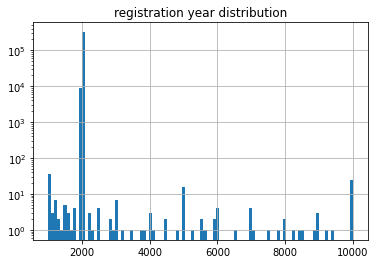

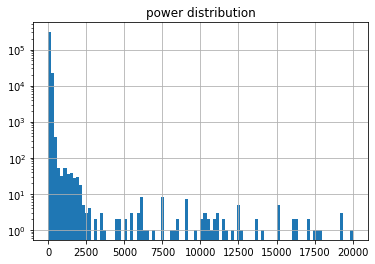

In [13]:
df['registration_year'].hist(bins=100, log=True)
plt.title('registration year distribution')
plt.show()

df['power'].hist(bins=100, log=True)
plt.title('power distribution')
plt.show()

Outliers in *registration_year* should be removed. Let's limit it by 1910-2019

Outliers in *power* should be removed. Let's limit it by 2000 ([link](https://en.wikipedia.org/wiki/List_of_production_cars_by_power_output))

In [14]:
df2 = pd.read_csv('/datasets/autos.csv') 

df2['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: object

In [15]:
df = df.query('1910<= registration_year <=2016 ')
df = df.query('power <=2000 ')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312824 entries, 0 to 326825
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               312824 non-null  int64 
 1   vehicle_type        291458 non-null  object
 2   registration_year   312824 non-null  int64 
 3   gear_box            297080 non-null  object
 4   power               312824 non-null  int64 
 5   model               296301 non-null  object
 6   kilometer           312824 non-null  int64 
 7   registration_month  312824 non-null  int64 
 8   fuel_type           287141 non-null  object
 9   brand               312824 non-null  object
 10  not_repaired        312824 non-null  int8  
 11  number_of_pictures  312824 non-null  int64 
dtypes: int64(6), int8(1), object(5)
memory usage: 28.9+ MB


Price checked, no outliers:

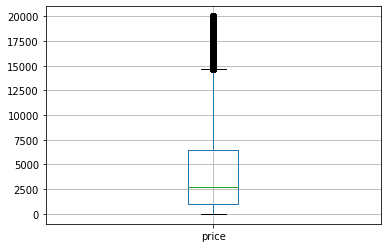

In [16]:
df.boxplot(["price"])
plt.show()

Let's check registration_month coulumn:

Removing **number_of_pictures** column:

In [17]:
df.drop(['number_of_pictures'], inplace=True, axis=1)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312824 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               312824 non-null  int64 
 1   vehicle_type        291458 non-null  object
 2   registration_year   312824 non-null  int64 
 3   gear_box            297080 non-null  object
 4   power               312824 non-null  int64 
 5   model               296301 non-null  object
 6   kilometer           312824 non-null  int64 
 7   registration_month  312824 non-null  int64 
 8   fuel_type           287141 non-null  object
 9   brand               312824 non-null  object
 10  not_repaired        312824 non-null  int8  
dtypes: int64(5), int8(1), object(5)
memory usage: 26.6+ MB


In [19]:
#filling missing model, vehicle_type, fuel_type,gear_box according to the most frequent values

df.model = df.groupby(['brand', 'registration_year'])['model'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.vehicle_type = df.groupby(['brand', 'model'])['vehicle_type'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.fuel_type = df.groupby(['brand', 'model'])['fuel_type'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))
df.gear_box = df.groupby(['brand', 'model'])['gear_box'].transform(lambda x: 
                                                                         x.fillna((x.mode()[0] if not x.mode().empty else "Unknown")))

In [20]:
df = df.replace('Unknown', np.nan)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312824 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               312824 non-null  int64 
 1   vehicle_type        312821 non-null  object
 2   registration_year   312824 non-null  int64 
 3   gear_box            312820 non-null  object
 4   power               312824 non-null  int64 
 5   model               309956 non-null  object
 6   kilometer           312824 non-null  int64 
 7   registration_month  312824 non-null  int64 
 8   fuel_type           312822 non-null  object
 9   brand               312824 non-null  object
 10  not_repaired        312824 non-null  int8  
dtypes: int64(5), int8(1), object(5)
memory usage: 26.6+ MB


1% of data is nan, we can drop it

In [21]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 309956 entries, 0 to 326825
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               309956 non-null  int64 
 1   vehicle_type        309956 non-null  object
 2   registration_year   309956 non-null  int64 
 3   gear_box            309956 non-null  object
 4   power               309956 non-null  int64 
 5   model               309956 non-null  object
 6   kilometer           309956 non-null  int64 
 7   registration_month  309956 non-null  int64 
 8   fuel_type           309956 non-null  object
 9   brand               309956 non-null  object
 10  not_repaired        309956 non-null  int8  
dtypes: int64(5), int8(1), object(5)
memory usage: 26.3+ MB


Correlation matrix


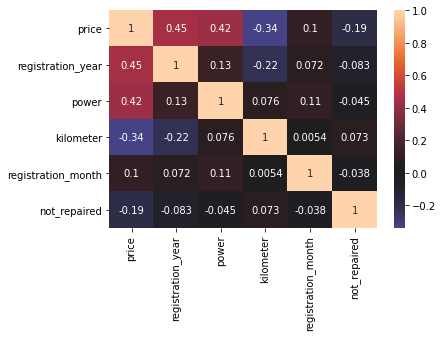

In [22]:
print('Correlation matrix')
sn.heatmap(df.corr(), annot=True, center=0)
plt.show()

No co-dependent features

### Вывод
Изучили датасет с данными по объявлениям о продаже автомобилей. Обработаны пропуски, дубликаты, удалены выбросы.
Колонки **date_crawled, last_seen, date_created, postal_code** удалены как неинформативные.

## Обучение моделей

In [23]:
categorical = ['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand']

target = df['price']

features_encoded = pd.get_dummies(df.drop(['price'], axis=1)) #, drop_first=True
features = df.drop(['price'], axis=1).copy()
features[categorical] = features[categorical].astype('category')  

In [24]:
#splitting the datasets
X_enc_train, X_enc_valid, y_train, y_valid = train_test_split(features_encoded, target, test_size=.25, random_state=25)

X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=.25, random_state=25)

for i in [X_enc_train, y_train, X_enc_valid, y_valid]:
    print(i.shape)

(232467, 311)
(232467,)
(77489, 311)
(77489,)


### Ridge

In [26]:
model = Ridge()

In [ ]:
%%time
distributions = dict(alpha=uniform(loc=0, scale=20))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_root_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_enc_train, y_train)

print(search.best_params_)
print('RMSE:', -search.best_score_)

### Gradient Boosting (LightGBM)

Проверим, как быстро работает LightGBM в зависимости от того, проводилось ли кодирование признаков исходно. Используем значения гиперпараметров по умолчанию.

In [25]:
model = lgb.LGBMRegressor(random_state=25)
callbacks = [lgb.log_evaluation(period=0)]

In [26]:
starttime = time.time()

model.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid), eval_metric='rmse', callbacks= callbacks )

print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

Best rmse:
 OrderedDict([('rmse', 1800.4558676616991), ('l2', 3241641.3313974417)])
Time spent, s: 54.05


In [41]:
starttime = time.time()

model.fit(X_train, y_train, categorical_feature=categorical, eval_set=(X_valid, y_valid), eval_metric='rmse', verbose=100)

print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's rmse: 1768.04	valid_0's l2: 3.12598e+06
Best rmse:
 OrderedDict([('rmse', 1768.0430531626891), ('l2', 3125976.237836844)])
Time spent, s: 6.48


LightGBM c некодированными категориальными признаками работает быстрее в три раза и дает лучшее качество. Будем использовать его для подбора параметров.

In [39]:
print(categorical)
X_train.dtypes

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand']


vehicle_type          category
registration_year        int64
gear_box              category
power                    int64
model                 category
kilometer                int64
registration_month       int64
fuel_type             category
brand                 category
not_repaired              int8
dtype: object

In [ ]:
%%time
model = lgb.LGBMRegressor(random_state=25, verbose=0)

distributions = dict(n_estimators=randint(1, 1000), max_depth=randint(1, 15), learning_rate=uniform(loc=0.01, scale=0.1))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_train, y_train, categorical_feature=categorical, eval_set=(X_valid, y_valid))

print(search.best_params_)
print('RMSE:', (-search.best_score_)**.5)
print('time for learning with these parameters, s:', 2*round(search.cv_results_['mean_fit_time'][search.best_index_], 2)) 

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'> Насколько я понимаю, L2 - это дефолтный лосс у LGBMR, попробуй передать в 'objective' => 'rmse'. </font>

In [35]:
starttime = time.time()

model.fit(X_train, y_train, categorical_feature=['brand', 'fuel_type', 'gear_box', 'model', 'vehicle_type'], eval_set=(X_valid, y_valid), eval_metric='rmse', verbose=100)

print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

/opt/conda/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['brand', 'fuel_type', 'gear_box', 'model', 'vehicle_type']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004921 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[100]	valid_0's rmse: 1768.04	valid_0's l2: 3.12598e+06
Best rmse:
 OrderedDict([('rmse', 1768.0430531626891), ('l2', 3125976.237836844)])
Time spent, s: 6.3


In [42]:
starttime = time.time()

model.fit(X_train, y_train, categorical_feature='auto', eval_set=(X_valid, y_valid), eval_metric='rmse', verbose=100)

print('Best rmse:\n', model.best_score_['valid_0'])
print(f"Time spent, s:", round(time.time() - starttime, 2))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005939 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[100]	valid_0's rmse: 1768.04	valid_0's l2: 3.12598e+06
Best rmse:
 OrderedDict([('rmse', 1768.0430531626891), ('l2', 3125976.237836844)])
Time spent, s: 6.99


In [48]:
model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': 25,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': 0}

In [40]:
print(categorical)
X_train.dtypes

['vehicle_type', 'gear_box', 'model', 'fuel_type', 'brand']


vehicle_type          category
registration_year        int64
gear_box              category
power                    int64
model                 category
kilometer                int64
registration_month       int64
fuel_type             category
brand                 category
not_repaired              int8
dtype: object

### CatBoost

Проверим, как быстро работает CatBoost в зависимости от того, проводилось ли кодирование признаков исходно. Используем значения гиперпараметров по умолчанию. 

In [27]:
model = CatBoostRegressor(random_state=25, verbose=200, eval_metric='RMSE')

In [29]:
starttime = time.time()
model.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid)) # 

print(f"Time spent, s:", round(time.time() - starttime, 2))

Learning rate set to 0.119788
0:	learn: 4194.0888245	test: 4202.2375115	best: 4202.2375115 (0)	total: 39.2ms	remaining: 39.2s
200:	learn: 1776.1743921	test: 1812.8333791	best: 1812.8333791 (200)	total: 5.78s	remaining: 23s
400:	learn: 1704.8616495	test: 1764.5443651	best: 1764.5443651 (400)	total: 11.4s	remaining: 17s
600:	learn: 1663.4422631	test: 1742.5800976	best: 1742.5800976 (600)	total: 17.3s	remaining: 11.5s
800:	learn: 1634.7973114	test: 1730.1289405	best: 1730.1289405 (800)	total: 23.4s	remaining: 5.82s
999:	learn: 1613.1468378	test: 1722.3103514	best: 1722.3103514 (999)	total: 29.3s	remaining: 0us

bestTest = 1722.310351
bestIteration = 999

Time spent, s: 32.68


In [30]:
starttime = time.time()
model.fit(X_train, y_train, cat_features=categorical, eval_set=(X_valid, y_valid))

print(f"Time spent, s:", round(time.time() - starttime, 2))

Learning rate set to 0.119788
0:	learn: 4202.7551151	test: 4212.5639532	best: 4212.5639532 (0)	total: 308ms	remaining: 5m 7s
200:	learn: 1754.4700816	test: 1789.4377069	best: 1789.4377069 (200)	total: 37.9s	remaining: 2m 30s
400:	learn: 1696.3308227	test: 1753.1106597	best: 1753.1106597 (400)	total: 1m 12s	remaining: 1m 48s
600:	learn: 1664.4158422	test: 1737.3700255	best: 1737.3700255 (600)	total: 1m 47s	remaining: 1m 11s
800:	learn: 1640.9660464	test: 1727.4821260	best: 1727.4338845 (799)	total: 2m 22s	remaining: 35.5s
999:	learn: 1622.9814779	test: 1720.4737649	best: 1720.4570753 (998)	total: 2m 57s	remaining: 0us

bestTest = 1720.457075
bestIteration = 998

Shrink model to first 999 iterations.
Time spent, s: 180.54


CatBoost c некодированными категориальными признаками работает дольше в 6 раз, и дает аналогичное качество. По этой причине будем использовать модель на предварительно закодированных данных для подбора параметров.

In [986]:
%%time
model = CatBoostRegressor(random_state=25, verbose=0)

distributions = dict(n_estimators=randint(1, 1000), max_depth=randint(1, 15), learning_rate=uniform(loc=0.01, scale=0.1))
reg = RandomizedSearchCV(model, distributions, random_state=25, scoring='neg_mean_squared_error', cv=2, n_iter=50, n_jobs=7)
search = reg.fit(X_enc_train, y_train, eval_set=(X_enc_valid, y_valid))

print(search.best_params_)
print('RMSE:', (-search.best_score_)**.5)
print('time for learning with these parameters, s:', 2*round(search.cv_results_['mean_fit_time'][search.best_index_], 2)) 

{'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641}
RMSE: 1743.9039171656339
time for learning with these parameters, s: 326.58
Wall time: 18min 13s


### Вывод
Для используемых моделей проводили подбор гиперпараметров путем рандомизации значений. Выяснилось, что для модели Ridge оптимальный параметр alpha=1.54.
Оптимальные гиперпараметры для моделей градиентного бустинга:
- LightGBM: *'learning_rate': 0.07209091874779094, 'max_depth': 14, 'n_estimators': 928*
- CatBoost: *'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641*

Установлено, что LightGBM c некодированными категориальными признаками работает быстрее в три раза и дает лучшее качество, в то время как первоначальный one-hot encoding делает обучение CatBoost быстрее в 6 раз.

## Анализ моделей

In [52]:
#arrays to save rmse and duration of fitting
time_learn, time_pred = [], []
rmse = []

**Ridge**

In [53]:
model=Ridge(alpha=1.54)

starttime = time.time()
model.fit(X_enc_train, y_train)
time_learn.append(round(time.time() - starttime, 2))

starttime = time.time()
pred = model.predict(X_enc_valid)
time_pred.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(model.predict(X_enc_valid), y_valid) ** 0.5))

**LightGBM**

In [ ]:
model = lgb.LGBMRegressor(random_state=25, verbose=200,  **{'learning_rate': 0.07209091874779094, 'max_depth': 14, 'n_estimators': 928})

starttime = time.time()
model.fit(X_train, y_train, categorical_feature='auto')
time_learn.append(round(time.time() - starttime, 2))

starttime = time.time()
pred = model.predict(X_valid)
time_pred.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(pred, y_valid) ** 0.5))

**CatBoost**

In [55]:
model = CatBoostRegressor(random_state=25, verbose=0, **{'learning_rate': 0.10120939993482243, 'max_depth': 13, 'n_estimators': 641})

starttime = time.time()
model.fit(X_enc_train, y_train)
time_learn.append(round(time.time() - starttime, 2))

starttime = time.time()
pred = model.predict(X_enc_valid)
time_pred.append(round(time.time() - starttime, 2))
rmse.append(round(mean_squared_error(pred, y_valid) ** 0.5))

In [56]:
pd.DataFrame(data={'Learning time, s':time_learn, 'Prediction time, s': time_pred, 'RMSE': rmse}, index=['Ridge', 'LightGBM', 'CatBoost'])

,"Learning time, s","Prediction time, s",RMSE
Ridge,2.91,0.50,2867
LightGBM,294.95,8.22,1693
CatBoost,104.87,0.36,1691


### Вывод
С подобранными параметрами обучили модели и сравнили времена обучения и качество. Быстрее всего обучается гребенчатая модель, однако качество очень плохое. Среди моделей градиентного бустинга намного быстрее обучается catboost (100 с против 290с секунд для lightgbm), и дает примерно одинаковое качество.  

## Общий вывод
Изучили датасет с данными по объявлениям о продаже автомобилей. Обработаны пропуски, дубликаты, удалены выбросы.

Далее проведен прогноз цены автомобиля на основании его характеристик. Для каждой из модели ML (гребенчатая, LightGBM, CatBoost) подобраны оптимальные параметры для достижения наименьшего значения метрики RMSE.

С подобранными параметрами обучили модели и сравнили времена обучения и качество. Быстрее всего обучается гребенчатая модель, однако качество очень плохое. Среди моделей градиентного бустинга намного быстрее обучается CatBoost (100 с против 290с секунд для lightgbm), и дает примерно одинаковое качество. Время предсказания для catboost составляет 0.4 с против 8.2 с для lightgbm.

**Для данной задачи оптимально использовать модель catboost ( лучшее качество при достаточно большой скорости обучения и предсказания)**